# Time Series con Gradient Boosting

## Introducción

Los modelos gradient boosting destacan dentro de la comunidad de machine learning debido a su capacidad para lograr excelentes resultados en una amplia variedad de casos de uso, incluyendo tanto la regresión como la clasificación. Aunque su uso en el forecasting de series temporales ha sido limitado, también pueden conseguir resultados muy competitivos en este ámbito. Algunas de las ventajas que presentan los modelos gradient boosting para forecasting son:

- La facilidad con que pueden incorporarse al modelo variables exógenas, además de las autorregresivas.

- La capacidad de capturar relaciones no lineales entre variables.

- Alta escalabilidad, que permite a los modelos manejar grandes volúmenes de datos.

- Algunas implementaciones permiten la inclusión de variables categóricas sin necesidad de codificación adicional, como la codificación one-hot.

A pesar de estas ventajas, el uso de modelos de machine learning para forecasting presenta varios retos que pueden hacer que el analista sea reticente a su uso, los principales son:

- Reestructurar los datos para poder utilizarlos como si se tratara de un problema de regresión.

- Dependiendo de cuántas predicciones futuras se necesiten (horizonte de predicción), puede ser necesario implementar un proceso iterativo en el que cada nueva predicción se base en las anteriores.

- La validación de los modelos requiere de estrategias específicas como backtesting, walk-forward validation o time series cross-validation. No puede aplicarse la validación cruzada tradicional.

La librería skforecast ofrece soluciones automatizadas a estos retos, facilitando el uso y la validación de modelos de machine learning en problemas de forecasting. Skforecast es compatible con las implementaciones de gradient boosting más avanzadas, incluyendo XGBoost, LightGBM, Catboost y HistGradientBoostingRegressor. Este documento muestra cómo utilizarlos para construir modelos de forecasting precisos.

## Caso de uso

Los sistemas de bicicletas compartidas, también conocidos como sistemas de bicicletas públicas, facilitan la disponibilidad automática de bicicletas para que sean utilizadas temporalmente como medio de transporte. La mayoría de estos sistemas permiten recoger una bicicleta y devolverla en un punto diferente (estaciones o dockers), para que el usuario solo necesite tener la bicicleta en su posesión durante el desplazamiento. Uno de los principales retos en la gestión de estos sistemas es la necesidad de redistribuir las bicicletas para intentar que, en todas las estaciones, haya bicicletas disponibles a la vez que espacios libres para devoluciones.

Con el objetivo de mejorar la planificación y ejecución de la distribución de las bicicletas, se plantea crear un modelo capaz de predecir el número de usuarios para las siguientes 36 horas. De esta forma, a las 12h de cada día, la compañía encargada de gestionar las estaciones de alquiler podrá conocer la demanda prevista el resto del día (12 horas) y el siguiente día (24 horas).

A efectos ilustrativos, el ejemplo actual sólo modela una estación, sin embargo, el modelo puede ampliarse para cubrir múltiples estaciones utilizando global multi-series forecasting, mejorando así la gestión de los sistemas de bicicletas compartidas a mayor escala.



## Librerías

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset

# Gráficos
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from skforecast.plot import plot_residuals
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
import xgboost
import lightgbm
import catboost
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

import skforecast
from skforecast.recursive._forecaster_equivalent_date import ForecasterEquivalentDate 
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
# from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")



## Datos

Los datos empleados en este documento representan el uso, a nivel horario, del sistema de alquiler de bicicletas en la ciudad de Washington D.C. durante los años 2011 y 2012. Además del número de usuarios por hora, se dispone de información sobre las condiciones meteorológicas y sobre los días festivos. Los datos originales se han obtenido del UCI Machine Learning Repository y han sido procesados previamente (código) aplicando las siguientes modificaciones :

- Columnas renombradas con nombres más descriptivos.

- Categorías de la variable meteorológica renombradas. La categoría de heavy rain, se ha combinado con la de rain.

- Variables de temperatura, humedad y viento desnormalizadas.

- Creada variable date_time y establecida como índice.

- Imputación de valores missing mediante forward fill.

In [2]:
# Descarga de datos
datos = fetch_dataset('bike_sharing', raw=True)

bike_sharing
------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, information
about weather conditions and holidays is available.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17544, 12)


In [3]:
datos

,date_time,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
0,2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0000,16.0,1,0,5
1,2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,40.0,1,1,5
2,2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,32.0,1,2,5
3,2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,13.0,1,3,5
4,2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,1.0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17539,2012-12-31 19:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,119.0,12,19,0
17540,2012-12-31 20:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,89.0,12,20,0
17541,2012-12-31 21:00:00,0.0,1.0,clear,10.66,12.880,60.0,11.0014,90.0,12,21,0
17542,2012-12-31 22:00:00,0.0,1.0,clear,10.66,13.635,56.0,8.9981,61.0,12,22,0


In [4]:
# Preprocesado de datos (estableciendo índice y frecuencia)
datos = datos[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('date_time')#
datos = datos.asfreq('h')
datos = datos.sort_index()
datos.head()

C:\Users\ronal\AppData\Local\Temp\ipykernel_14912\223580837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['date_time'] = pd.to_datetime(datos['date_time'], format='%Y-%m-%d %H:%M:%S')


,users,holiday,weather,temp,atemp,hum,windspeed
date_time,,,,,,,
2011-01-01 00:00:00,16.0,0.0,clear,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,40.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,32.0,0.0,clear,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,13.0,0.0,clear,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,clear,9.84,14.395,75.0,0.0


Con el objetivo de poder entrenar los modelos, hacer búsqueda de los mejores hiperparámetros y evaluar su capacidad predictiva, se reparten los datos en tres conjuntos: entrenamiento, validación y test.

In [5]:
# Separación de datos en entrenamiento, validación y test
fin_train = '2012-03-31 23:59:00'
fin_validacion = '2012-08-31 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]
print(
    f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  "
    f"(n={len(datos_train)})"
)
print(
    f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  "
    f"(n={len(datos_val)})"
)
print(
    f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  "
    f"(n={len(datos_test)})"
)

Fechas train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Fechas validación : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Fechas test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


## Exploración gráfica

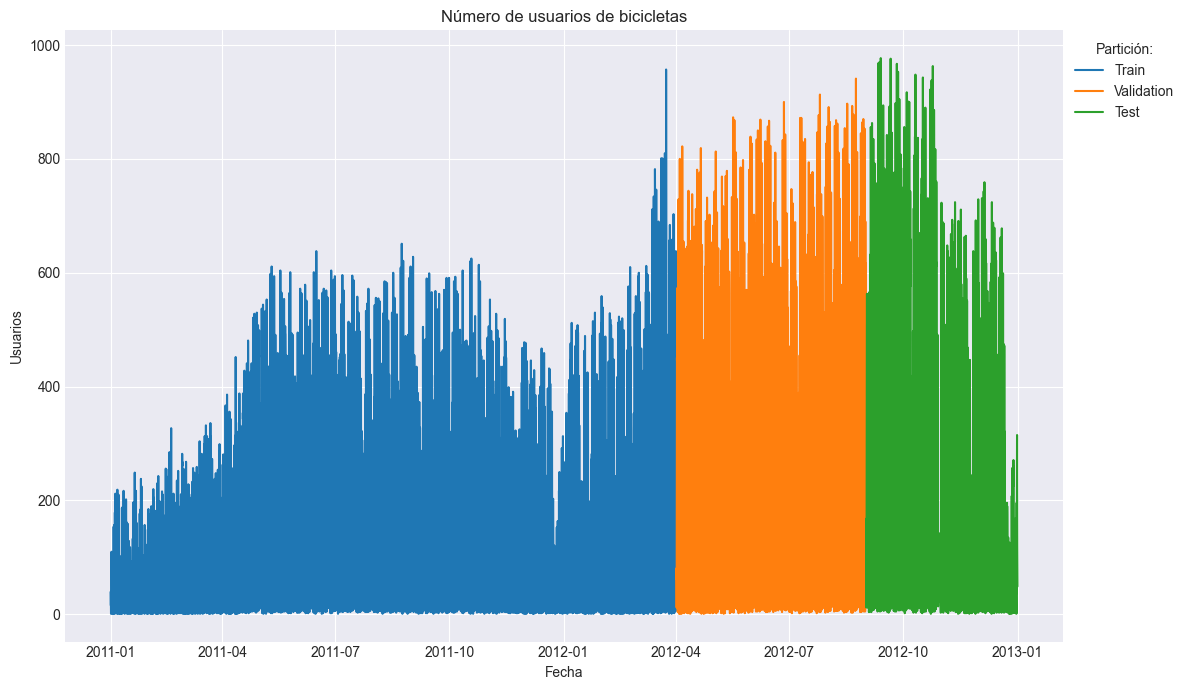

In [6]:

# Crear el gráfico de las tres series temporales
plt.figure(figsize=(12, 7))  # Tamaño más pequeño

plt.plot(datos_train.index, datos_train['users'], label='Train')
plt.plot(datos_val.index, datos_val['users'], label='Validation')
plt.plot(datos_test.index, datos_test['users'], label='Test')

# Configurar títulos y etiquetas
plt.title('Número de usuarios de bicicletas')
plt.xlabel('Fecha')
plt.ylabel('Usuarios')

# Configurar la leyenda
plt.legend(title="Partición:", loc='upper left', bbox_to_anchor=(1, 1))

# Eliminar márgenes innecesarios
plt.tight_layout()

# Mostrar gráfico
plt.show()


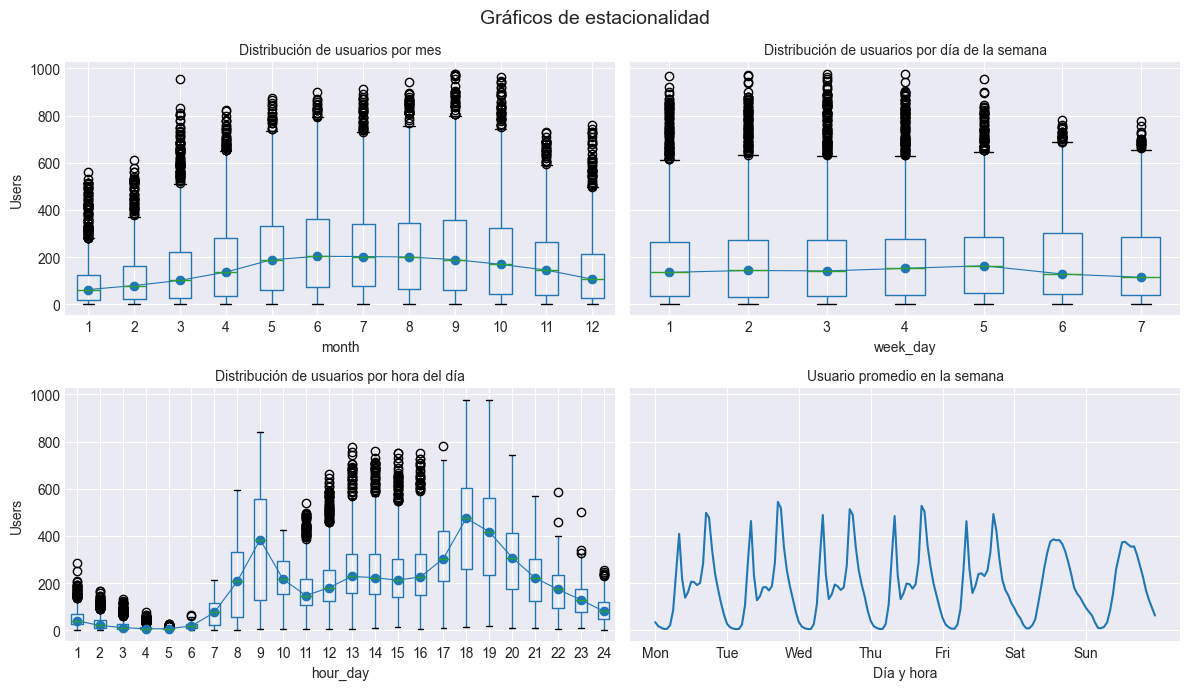

In [7]:
# Estacionalidad anual, semanal y diaria
fig, axs = plt.subplots(2, 2, figsize=(12, 7), sharex=False, sharey=True)
axs = axs.ravel()

# Distribución de usuarios por mes
datos['month'] = datos.index.month
datos.boxplot(column='users', by='month', ax=axs[0])
datos.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Distribución de usuarios por mes', fontsize=10)

# Distribución de usuarios por día de la semana
datos['week_day'] = datos.index.day_of_week + 1
datos.boxplot(column='users', by='week_day', ax=axs[1])
datos.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Distribución de usuarios por día de la semana', fontsize=10)

# Distribución de usuarios por hora del día
datos['hour_day'] = datos.index.hour + 1
datos.boxplot(column='users', by='hour_day', ax=axs[2])
datos.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Distribución de usuarios por hora del día', fontsize=10)

# Distribución de usuarios por día de la semana y hora del día
mean_day_hour = datos.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Usuario promedio en la semana",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Día y hora",
    ylabel      = "Users"
)
axs[3].title.set_size(10)

fig.suptitle("Gráficos de estacionalidad", fontsize=14)
fig.tight_layout()

Existe una clara diferencia entre los días entre semana y el fin de semana. También se observa un claro patrón intradiario, con diferente afluencia de usuarios dependiendo de la hora del día.

Los gráficos de autocorrelación muestran la correlación entre una serie temporal y sus valores pasados. Son una herramienta útil para identificar el orden de un modelo autorregresivo, es decir, los valores pasados (lags) que se deben incluir en el modelo.

La función de autocorrelación (ACF) mide la correlación entre una serie temporal y sus valores pasados. La función de autocorrelación parcial (PACF) mide la correlación entre una serie temporal y sus valores pasados, pero solo después de eliminar las variaciones explicadas por los valores pasados intermedios.

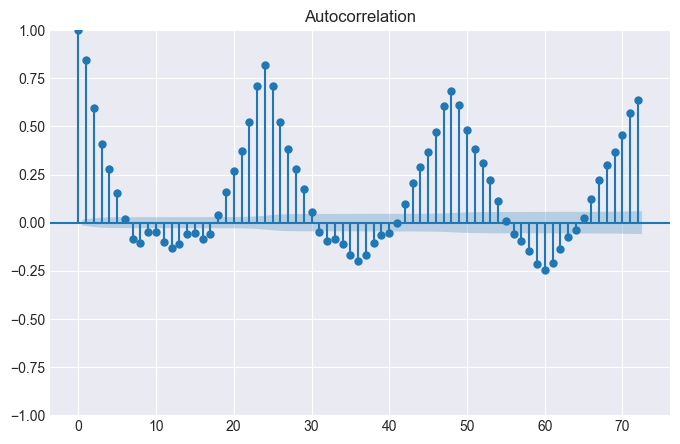

In [8]:
# Gráfico autocorrelación
fig, ax = plt.subplots(figsize=(8, 5))
plot_acf(datos['users'], ax=ax, lags=72)
plt.show()

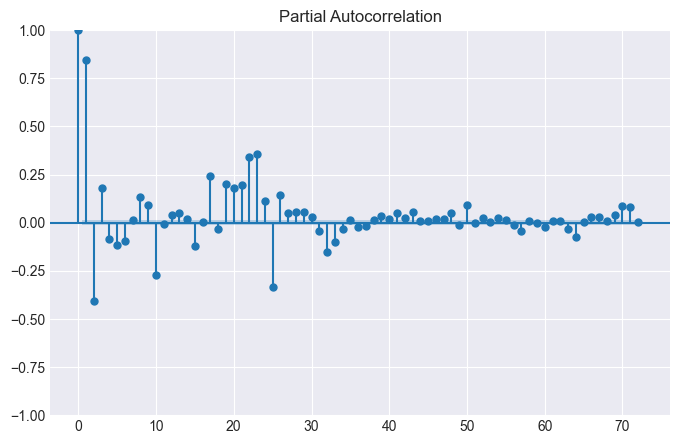

In [9]:
# Gráfico autocorrelación parcial
fig, ax = plt.subplots(figsize=(8, 5))
plot_pacf(datos['users'], ax=ax, lags=72)
plt.show()

Los resultados del estudio de autocorrelación indican una correlación significativa entre el número de usuarios en las horas anteriores, así como en los días previos. Esto significa que conocer del número de usuarios durante periodos específicos del pasado proporciona información útil para predecir el número de usuarios en el futuro.

## Baseline

Al enfrentarse a un problema de forecasting, es recomendable disponer de un modelo de referencia (baseline). Se trata de un modelo muy sencillo que puede utilizarse como referencia para evaluar si merece la pena aplicar modelos más complejos(principio de parsimonia).

Skforecast permite crear fácilmente un modelo de referencia con su clase ForecasterEquivalentDate. Este modelo, también conocido como Seasonal Naive Forecasting, simplemente devuelve el valor observado en el mismo periodo de la temporada anterior (por ejemplo, el mismo día laboral de la semana anterior, la misma hora del día anterior, etc.).

A partir del análisis exploratorio realizado, el modelo de referencia será el que prediga cada hora utilizando el valor de la misma hora del día anterior.

In [10]:
# Crear un baseline: valor de la misma hora del día anterior
forecaster = ForecasterEquivalentDate(
    offset    = pd.DateOffset(days=1),
    n_offsets = 1
)

# Entremaiento del forecaster
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Creation date: 2025-02-12 17:04:20 
Last fit date: 2025-02-12 17:04:20 
Skforecast version: 0.14.0 
Python version: 3.11.3 
Forecaster id: None 

In [11]:
cv = TimeSeriesFold(
             steps              = 36,
             initial_train_size = len(datos.loc[:fin_validacion]),
             refit              = False,
             fixed_train_size   = False,
         )
# Backtesting
metrica_baseline, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    cv                 = cv,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_baseline

  0%|          | 0/82 [00:00<?, ?it/s]

,mean_absolute_error
0,91.668716


El modelo baseline alcanza un MAE de 91,7, que se utiliza como referencia para evaluar si merece la pena aplicar los modelos más complejos.

## Modelo autoregresivo recursivo con LightGBM

``LightGBM`` es una implementación altamente eficiente del algoritmo gradient boosting, que se ha convertido en un referente en el campo del machine learning. La librería LightGBM incluye su propia API, así como la API de scikit-learn, lo que la hace compatible con skforecast.

En primer lugar, se entrena un modelo **ForecasteRecursive** utilizando valores pasados de la variable de respuesta (lags) como predictores. Posteriormente, se añaden variables exógenas al modelo y se evalúa la mejora de su rendimiento. Dado que los modelos de Gradient Boosting tienen un gran número de hiperparámetros, se realiza una **Búsqueda Bayesiana** utilizando la función ``bayesian_search_forecaster()`` para encontrar la mejor combinación de hiperparámetros y lags. Por último, se evalúa la capacidad predictiva del modelo mediante un proceso de backtesting.

In [12]:
# from graphviz import Digraph

# # Crear el objeto Digraph con disposición horizontal (rankdir='LR')
# dot = Digraph(format='png')
# dot.attr(rankdir='LR')  # Layout de izquierda a derecha

# # Definir los nodos
# dot.node('A', 'Entrenar modelo\nForecasterRecursive')
# dot.node('B', 'Añadir variables\nexógenas')
# dot.node('C', 'Evaluar mejora del\nrendimiento')
# dot.node('D', 'Búsqueda Bayesiana\nde hiperparámetros')
# dot.node('E', 'Backtesting del modelo')

# # Definir las conexiones
# dot.edge('A', 'B')
# dot.edge('B', 'C')
# dot.edge('C', 'D')
# dot.edge('D', 'E')

# # Mostrar el diagrama
# dot


## **Forecaster**

In [13]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 24,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=datos.loc[:fin_validacion, 'users'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-02-12 17:04:20 
Last fit date: 2025-02-12 17:04:21 
Skforecast version: 0.14.0 
Python version: 3.11.3 
Forecaster id: None

In [14]:
# Predicciones
forecaster.predict(steps=10)


2012-09-01 00:00:00    108.331027
2012-09-01 01:00:00     68.562982
2012-09-01 02:00:00     33.499525
2012-09-01 03:00:00     10.027583
2012-09-01 04:00:00      3.037563
2012-09-01 05:00:00     17.162543
2012-09-01 06:00:00     51.059825
2012-09-01 07:00:00    146.940053
2012-09-01 08:00:00    344.320596
2012-09-01 09:00:00    439.738683
Freq: h, Name: pred, dtype: float64

### Backtesting
Para obtener una estimación robusta de la capacidad predictiva del modelo, se realiza un proceso de backtesting. El proceso de backtesting consiste en generar una predicción para cada observación del conjunto de test, siguiendo el mismo procedimiento que se seguiría si el modelo estuviese en producción, y finalmente comparar el valor predicho con el valor real.

In [15]:
# Backtest model on test data
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos[:fin_validacion]),
        refit              = False,
)

# Backtest del modelo con lo datos de test
metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    cv                 = cv,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False, # Cambiar a True para mostrar mas información
    show_progress      = True
)
predicciones.head()

  0%|          | 0/82 [00:00<?, ?it/s]

,pred
2012-09-01 00:00:00,108.331027
2012-09-01 01:00:00,68.562982
2012-09-01 02:00:00,33.499525
2012-09-01 03:00:00,10.027583
2012-09-01 04:00:00,3.037563


In [16]:
metrica

,mean_absolute_error
0,76.464247


El error de predicción del modelo autorregresivo alcanza un MAE inferior al del modelo de referencia.

### Optimización de hiperparámetros (tuning)

El **ForecasterRecursive** entrenado utiliza los primeros 24 lags y un modelo **LGMBRegressor** con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para encontrar los mejores hiperparámetros, se realiza una **Búsqueda Bayesiana** con la función **bayesian_search_forecaster()**. La búsqueda se lleva a cabo utilizando el mismo proceso de backtesting que antes, pero cada vez, el modelo se entrena con diferentes combinaciones de hiperparámetros y lags. Es importante señalar que la búsqueda de hiperparámetros debe realizarse utilizando el conjunto de validación, nunca con los datos de test.

La búsqueda se realiza probando cada combinación de hiperparámetros y retardos del siguiente modo:

1. Entrenar el modelo utilizando sólo el conjunto de entrenamiento.

2. El modelo se evalúa utilizando el conjunto de validación mediante backtesting.

3. Seleccionar la combinación de hiperparámetros y retardos que proporcione el menor error.

4. Volver a entrenar el modelo con la mejor combinación encontrada, esta vez utilizando tanto los datos de entrenamiento como los de validación.

Siguiendo estos pasos, se puede obtener un modelo con hiperparámetros optimizados y evitar el sobreajuste.

In [17]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Búsqueda de hiperparámetros
# Lags candidatos
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


cv = TimeSeriesFold(
        initial_train_size = len(datos_train),
        steps              = 36,
        refit              = False,
        )


resultados_busqueda, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'], # Datos test no incluidos
    search_space       = search_space,
    cv                 = cv,
    metric             = 'mean_absolute_error',
    n_trials           = 20, # Aumentar para una búsqueda más exhaustiva
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 900, 'max_depth': 9, 'min_data_in_leaf': 174, 'learning_rate': 0.1304758710430311, 'feature_fraction': 1.0, 'max_bin': 250, 'reg_alpha': 0.0, 'reg_lambda': 0.4}
  Backtesting metric: 74.3179709002173


In [18]:
# Resultados de la búsqueda
resultados_busqueda.head(10)

,lags,params,mean_absolute_error,n_estimators,max_depth,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
0,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 900, 'max_depth': 9, 'min_dat...",74.317971,900.0,9.0,174.0,0.130476,1.0,250.0,0.0,0.4
1,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 900, 'max_depth': 9, 'min_dat...",75.331228,900.0,9.0,165.0,0.158407,0.9,225.0,0.0,0.5
2,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 6, 'min_dat...",75.651879,800.0,6.0,173.0,0.218912,1.0,250.0,0.5,0.6
3,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 10, 'min_da...",76.514609,800.0,10.0,492.0,0.013950,1.0,250.0,0.9,0.2
4,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 9, 'min_dat...",77.548343,800.0,9.0,225.0,0.095124,1.0,250.0,0.8,0.0
5,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 400, 'max_depth': 8, 'min_dat...",78.622751,400.0,8.0,183.0,0.363259,1.0,250.0,0.3,0.3
6,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 800, 'max_depth': 10, 'min_da...",78.880580,800.0,10.0,483.0,0.018117,1.0,250.0,0.9,0.2
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 4, 'min_da...",79.163603,1000.0,4.0,117.0,0.290504,0.5,225.0,0.6,0.7
8,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1000, 'max_depth': 6, 'min_da...",80.017856,1000.0,6.0,53.0,0.205042,0.9,75.0,0.1,0.5
9,"[1, 2, 3, 23, 24, 25, 167, 168, 169]","{'n_estimators': 1200, 'max_depth': 10, 'min_d...",82.537594,1200.0,10.0,481.0,0.107171,1.0,200.0,0.4,0.3


In [19]:
# Mejor modelo
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3  23  24  25 167 168 169] 
Window features: ['roll_mean_72'] 
Window size: 169 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2011-01-01 00:00:00'), Timestamp('2012-08-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1304758710430311,
    'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 900, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0,
    'reg_lambda': 0.4, 'subsample': 1.0, 'subsample_for_bin': 200000,
    'subsample_freq': 0, 'verbose': -1, 'min_data_in_leaf': 174,
    'feature_fraction': 1.0, 'max_bin': 250} 
fit_kwargs: {} 
Creation date: 2025-02-12 17:04:20 
Last fit date: 2025-02-12 17:05:39 
Skforecast version: 0.14.0 
Python version: 3.11.3 
Forecaster id: None

### Backtesting con datos de test

Una vez identificada la mejor combinación de hiperparámetros utilizando los datos de validación, se evalúa la capacidad predictiva del modelo cuando se aplica al conjunto de test. Se recomienda revisar la documentación de la función **backtesting_forecaster** para comprender mejor sus capacidades. Esto ayudará a utilizar todo su potencial para analizar la capacidad predictiva del modelo.

In [20]:
# Backtest modelo final con datos de test
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos[:fin_validacion]),
        refit              = False,
     )
# 

metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    cv=cv,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
print('El MAE es:', metrica)
predicciones.head()

  0%|          | 0/82 [00:00<?, ?it/s]

El MAE es:    mean_absolute_error
0            63.905665


,pred
2012-09-01 00:00:00,135.957964
2012-09-01 01:00:00,110.650421
2012-09-01 02:00:00,71.372960
2012-09-01 03:00:00,33.210049
2012-09-01 04:00:00,8.752417


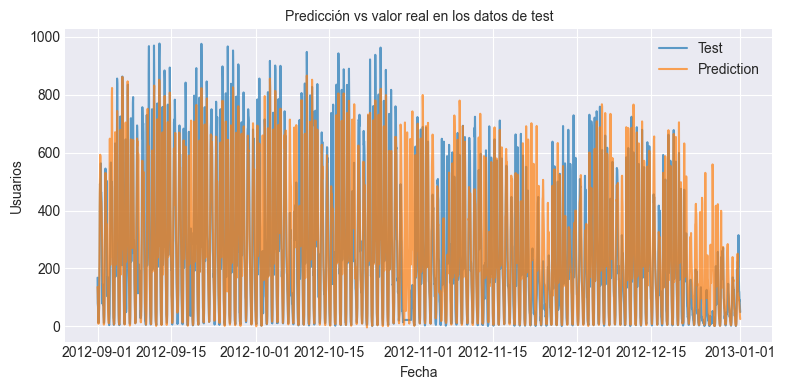

In [21]:

# Configuración de la figura
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar la serie real y la predicción
ax.plot(datos_test.index, datos_test['users'], label="Test", linestyle='-', alpha=0.7)
ax.plot(predicciones.index, predicciones['pred'], label="Prediction", linestyle='-', alpha=0.7)

# Ajustes del gráfico
ax.set_xlabel("Fecha")
ax.set_ylabel("Usuarios")
ax.set_title("Predicción vs valor real en los datos de test", fontsize=10)
ax.legend()

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Tras optimizar los lags y los hiperparámetros, el error de predicción del modelo autorregresivo alcanza un MAE significativamente inferior al del modelo de referencia. A continuación, se evalúa la capacidad predictiva del modelo cuando se añaden variables exógenas.

### Variables exógenas
Hasta ahora, sólo se han utilizado como predictores los valores pasados (lags) de la serie temporal. Sin embargo, es posible incluir otras variables como predictores. Estas variables se conocen como variables exógenas (features) y su uso puede mejorar la capacidad predictiva del modelo. Un punto muy importante que hay que tener en cuenta es que los valores de las variables exógenas deben conocerse en el momento de la predicción.

Ejemplos habituales de variables exógenas son aquellas obtenidas del calendario, como el día de la semana, el mes, el año o los días festivos. Las variables meteorológicas como la temperatura, la humedad y el viento también entran en esta categoría, al igual que las variables económicas como la inflación y los tipos de interés.

### Variables de calendario y meteorológicas

A continuación, se crean variables exógenas basadas en información del calendario, las horas de salida y puesta del sol, la temperatura y los días festivos. Estas nuevas variables se añaden a los conjuntos de entrenamiento, validación y test, y se utilizan como predictores en el modelo autorregresivo.

In [22]:
# Variables basadas en el calendario
variables_calendario = pd.DataFrame(index=datos.index)
variables_calendario['mes'] = variables_calendario.index.month
variables_calendario['semana_anyo'] = variables_calendario.index.isocalendar().week
variables_calendario['dia_semana'] = variables_calendario.index.day_of_week + 1
variables_calendario['hora_dia'] = variables_calendario.index.hour + 1

# Variables basadas en la luz solar
location = LocationInfo(
    name      = 'Washington DC',
    region    = 'USA',
    timezone  = 'US/Eastern',
    latitude  = 40.516666666666666,
    longitude = -77.03333333333333
)
hora_amanecer = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in datos.index
]
hora_anochecer = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in datos.index
]
variables_solares = pd.DataFrame({
                         'hora_amanecer': hora_amanecer,
                         'hora_anochecer': hora_anochecer}, 
                         index = datos.index
                     )
variables_solares['horas_luz_solar'] = (
    variables_solares['hora_anochecer'] - variables_solares['hora_amanecer']
)
variables_solares["es_de_dia"] = np.where(
    (datos.index.hour >= variables_solares["hora_amanecer"])
    & (datos.index.hour < variables_solares["hora_anochecer"]),
    1,
    0,
)

# Variables basadas en festivos
variables_festivos = datos[['holiday']].astype(int)
variables_festivos['holiday_dia_anterior'] = variables_festivos['holiday'].shift(24)
variables_festivos['holiday_dia_siguiente'] = variables_festivos['holiday'].shift(-24)

# Variables basadas en temperatura
variables_temp = datos[['temp']].copy()
variables_temp['temp_roll_mean_1_dia'] = variables_temp['temp'].rolling(24, closed='left').mean()
variables_temp['temp_roll_mean_7_dia'] = variables_temp['temp'].rolling(24*7, closed='left').mean()
variables_temp['temp_roll_max_1_dia'] = variables_temp['temp'].rolling(24, closed='left').max()
variables_temp['temp_roll_min_1_dia'] = variables_temp['temp'].rolling(24, closed='left').min()
variables_temp['temp_roll_max_7_dia'] = variables_temp['temp'].rolling(24*7, closed='left').max()
variables_temp['temp_roll_min_7_dia'] = variables_temp['temp'].rolling(24*7, closed='left').min()


# Fusionar todas las variables exógenas
variables_exogenas = pd.concat([
    variables_calendario,
    variables_solares,
    variables_temp,
    variables_festivos
], axis=1)

variables_exogenas.head()

,mes,semana_anyo,dia_semana,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,temp,temp_roll_mean_1_dia,temp_roll_mean_7_dia,temp_roll_max_1_dia,temp_roll_min_1_dia,temp_roll_max_7_dia,temp_roll_min_7_dia,holiday,holiday_dia_anterior,holiday_dia_siguiente
date_time,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 03:00:00,1,52,6,4,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0
2011-01-01 04:00:00,1,52,6,5,7,16,9,0,9.84,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0


#### Variables con patrones cíclicos

Algunos aspectos del calendario, como las horas o los días, son cíclicos. Por ejemplo, la hora del día va de 0 a 23 horas. Este tipo de variables pueden tratarse de varias formas, cada una con sus ventajas e inconvenientes.

- Un enfoque consiste en utilizar las variables directamente como valores numéricos sin ninguna transformación. Este método evita crear variables nuevas, pero puede imponer un orden lineal incorrecto a los valores. Por ejemplo, la hora 23 de un día y la hora 00 del siguiente están muy alejadas en su representación lineal, cuando en realidad sólo hay una hora de diferencia entre ellas.

- Otra posibilidad es tratar las variables cíclicas como variables categóricas para evitar imponer un orden lineal. Sin embargo, este enfoque puede provocar la pérdida de la información cíclica inherente a la variable.

- Existe una tercera forma de tratar las variables cíclicas que suele preferirse a los otros dos métodos. Se trata de transformar las variables utilizando el seno y el coseno de su periodo. Este método genera solo dos nuevas variables que captan la ciclicidad de los datos con mayor precisión que los dos métodos anteriores, ya que preserva el orden natural de la variable y evita imponer un orden lineal.

In [23]:
# Codificación cíclica de las variables de calendario y luz solar
def codificacion_ciclica(datos: pd.Series, longitud_ciclo: int) -> pd.DataFrame:
    """
    Codifica una variable cíclica con dos nuevas variables: seno y coseno.
    Se asume que el valor mínimo de la variable es 0. El valor máximo de la
    variable se pasa como argumento.
      
    Parameters
    ----------
    datos : pd.Series
        Serie con la variable a codificar.
    longitud_ciclo : int
        La longitud del ciclo. Por ejemplo, 12 para meses, 24 para horas, etc.
        Este valor se utiliza para calcular el ángulo del seno y coseno.

    Returns
    -------
    resultado : pd.DataFrame
        Dataframe con las dos nuevas características: seno y coseno.

    """

    seno = np.sin(2 * np.pi * datos/longitud_ciclo)
    coseno = np.cos(2 * np.pi * datos/longitud_ciclo)
    resultado =  pd.DataFrame({
                  f"{datos.name}_seno": seno,
                  f"{datos.name}_coseno": coseno
              })

    return resultado


mes_encoded = codificacion_ciclica(variables_exogenas['mes'], longitud_ciclo=12)
semana_anyo_encoded = codificacion_ciclica(variables_exogenas['semana_anyo'], longitud_ciclo=52)
dia_semana_encoded = codificacion_ciclica(variables_exogenas['dia_semana'], longitud_ciclo=7)
hora_dia_encoded = codificacion_ciclica(variables_exogenas['hora_dia'], longitud_ciclo=24)
hora_amanecer_encoded = codificacion_ciclica(variables_exogenas['hora_amanecer'], longitud_ciclo=24)
hora_anochecer_encoded = codificacion_ciclica(variables_exogenas['hora_anochecer'], longitud_ciclo=24)

variables_ciclicas = pd.concat([
                            mes_encoded,
                            semana_anyo_encoded,
                            dia_semana_encoded,
                            hora_dia_encoded,
                            hora_amanecer_encoded,
                            hora_anochecer_encoded
                        ], axis=1)  

variables_exogenas = pd.concat([variables_exogenas, variables_ciclicas], axis=1)
variables_exogenas.head()

,mes,semana_anyo,dia_semana,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,temp,temp_roll_mean_1_dia,...,semana_anyo_seno,semana_anyo_coseno,dia_semana_seno,dia_semana_coseno,hora_dia_seno,hora_dia_coseno,hora_amanecer_seno,hora_amanecer_coseno,hora_anochecer_seno,hora_anochecer_coseno
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,...,0.0,1.0,-0.781831,0.62349,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,...,0.0,1.0,-0.781831,0.62349,0.500000,0.866025,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,...,0.0,1.0,-0.781831,0.62349,0.707107,0.707107,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 03:00:00,1,52,6,4,7,16,9,0,9.84,NaN,...,0.0,1.0,-0.781831,0.62349,0.866025,0.500000,0.965926,-0.258819,-0.866025,-0.5
2011-01-01 04:00:00,1,52,6,5,7,16,9,0,9.84,NaN,...,0.0,1.0,-0.781831,0.62349,0.965926,0.258819,0.965926,-0.258819,-0.866025,-0.5


#### Interacción entre variables

En muchos casos, las variables exógenas no son independientes. Más bien, su efecto sobre la variable objetivo depende del valor de otras variables. Por ejemplo, el efecto de la temperatura en la demanda de electricidad depende de la hora del día. La interacción entre las variables exógenas puede captarse mediante nuevas variables que se obtienen multiplicando entre sí las variables existentes. Estas interacciones se obtienen fácilmente con la clase PolynomialFeatures de scikit-learn.

In [24]:
# Interacción entre variables exógenas
transformer_poly = PolynomialFeatures(
    degree           = 2,
    interaction_only = True,
    include_bias     = False
).set_output(transform="pandas")

poly_cols = [
    'mes_seno',
    'mes_coseno',
    'semana_anyo_seno',
    'semana_anyo_coseno',
    'dia_semana_seno',
    'dia_semana_coseno',
    'hora_dia_seno',
    'hora_dia_coseno',
    'hora_amanecer_seno',
    'hora_amanecer_coseno',
    'hora_anochecer_seno',
    'hora_anochecer_coseno',
    'horas_luz_solar',
    'es_de_dia',
    'holiday_dia_anterior',
    'holiday_dia_siguiente',
    'temp_roll_mean_1_dia',
    'temp_roll_mean_7_dia',
    'temp_roll_max_1_dia',
    'temp_roll_min_1_dia',
    'temp_roll_max_7_dia',
    'temp_roll_min_7_dia',
    'temp',
    'holiday'
]

variables_poly = transformer_poly.fit_transform(variables_exogenas[poly_cols].dropna())
variables_poly = variables_poly.drop(columns=poly_cols)
variables_poly.columns = [f"poly_{col}" for col in variables_poly.columns]
variables_poly.columns = variables_poly.columns.str.replace(" ", "__")
variables_exogenas = pd.concat([variables_exogenas, variables_poly], axis=1)
variables_exogenas.head()

,mes,semana_anyo,dia_semana,hora_dia,hora_amanecer,hora_anochecer,horas_luz_solar,es_de_dia,temp,temp_roll_mean_1_dia,...,poly_temp_roll_min_1_dia__temp_roll_max_7_dia,poly_temp_roll_min_1_dia__temp_roll_min_7_dia,poly_temp_roll_min_1_dia__temp,poly_temp_roll_min_1_dia__holiday,poly_temp_roll_max_7_dia__temp_roll_min_7_dia,poly_temp_roll_max_7_dia__temp,poly_temp_roll_max_7_dia__holiday,poly_temp_roll_min_7_dia__temp,poly_temp_roll_min_7_dia__holiday,poly_temp__holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,52,6,1,7,16,9,0,9.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,1,52,6,2,7,16,9,0,9.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,1,52,6,3,7,16,9,0,9.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,1,52,6,4,7,16,9,0,9.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 04:00:00,1,52,6,5,7,16,9,0,9.84,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Variables categóricas

Existen varios enfoques para incorporar variables categóricas en LightGBM (y otras implementaciones de gradient boosting):

- Una opción es transformar los datos convirtiendo los valores categóricos en valores numéricos utilizando métodos como la codificación one hot la codificación ordinal. Este enfoque es aplicable a todos los modelos de aprendizaje automático.

- LightGBM puede manejar variables categóricas internamente sin necesidad de preprocesamiento. Esto puede hacerse automáticamente estableciendo el parámetro categorical_features='auto' y almacenando las variables con el tipo de dato category dentro de un Pandas DataFrame. Tambien es posible especificar los nombres de las variables a tratar como categóricas pasando una lista de nombres al parámetro categorical_features.

No hay un método que sea siempre mejor que los otros. Las reglas generales son:

- Cuando la cardinalidad de las variables categóricas es alta (muchos valores diferentes), es mejor utilizar el soporte nativo para variables categóricas que utilizar la codificación one-hot.

- Con datos codificados con one hot encoding, se necesitan más puntos de división (es decir, más profundidad) para recuperar una división equivalente a la que podría obtenerse con un solo punto de división utilizando el tratamiento nativo.

- Cuando una variable categórica se convierte en múltiples variables dummy utilizando one hot encoding, su importancia se diluye, haciendo que el análisis de la importancia de las características sea más complejo de interpretar.

In [25]:
# Almacenar las variables categoricas como tipo "category"
datos["weather"] = datos["weather"].astype("category")

#### One hot encoding
ColumnTransformers en scikit-learn proporcionan una potente forma de definir transformaciones y aplicarlas a variables específicas. Al encapsular las transformaciones en un objeto ColumnTransformer, se puede pasar a un Forecaster utilizando el argumento ``transformer_exog``.

In [26]:
# Transformación con codificación one-hot
one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, drop='if_binary'),
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")  

In [27]:
# Crear un forecaster con un transformer para las variables exógenas
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = one_hot_encoder
)

Para examinar cómo se transforman los datos, se puede utilizar el método **create_train_X_y** y generar las matrices que el forecaster utiliza para entrenar el modelo. Este método permite conocer las manipulaciones específicas de los datos que se producen durante el proceso de entrenamiento.

In [28]:
# Mostrar matrices de entrenamiento
exog_cols = ['weather']        
X_train, y_train = forecaster.create_train_X_y(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)
X_train.head()

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,weather_clear,weather_mist,weather_rain
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-04 00:00:00,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,72.0,77.0,...,2.0,1.0,1.0,13.0,32.0,40.0,16.0,1.0,0.0,0.0
2011-01-04 01:00:00,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,72.0,...,3.0,2.0,1.0,1.0,13.0,32.0,40.0,1.0,0.0,0.0
2011-01-04 02:00:00,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,76.0,...,8.0,3.0,2.0,1.0,1.0,13.0,32.0,1.0,0.0,0.0
2011-01-04 03:00:00,1.0,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,157.0,...,14.0,8.0,3.0,2.0,1.0,1.0,13.0,1.0,0.0,0.0
2011-01-04 04:00:00,1.0,1.0,2.0,5.0,12.0,20.0,52.0,52.0,110.0,157.0,...,36.0,14.0,8.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0


La estrategia One Hot Encoder se ha mostrado con fines didácticos. Para el resto del notebook, sin embargo, se utiliza el soporte nativo para variables categóricas.

### Implementación nativa para variables categóricas

Las librerías de Gradient Boosting (XGBoost, LightGBM, CatBoost y HistGradientBoostingRegressor) asumen que las variables de entrada son números enteros empezando por 0 hasta el número de categorías [0, 1, ..., n_categories-1]. En la mayoría de los casos reales, las variables categóricas no se codifican con números sino con cadenas (strings), por lo que es necesario un paso intermedio de transformación. Existen dos opciones:

- Asignar a las columnas con variables categóricas el tipo category. Internamente, esta estructura de datos consiste en una matriz de categorías y una matriz de valores enteros (códigos) que apuntan al valor real de la matriz de categorías. Es decir, internamente es una matriz numérica con un mapeo que relaciona cada valor con una categoría. Los modelos son capaces de identificar automáticamente las columnas de tipo category y acceder a sus códigos internos. Este enfoque es aplicable a XGBoost, LightGBM y CatBoost.

- Preprocesar las columnas categóricas con un OrdinalEncoder para transformar sus valores a enteros y luego indicar explícitamente que deben ser tratadas como categóricas.

Para utilizar la detección automática en skforecast, las variables categóricas deben codificarse primero como enteros y luego almacenarse de nuevo como tipo category. Esto se debe a que skforecast utiliza internamente una matriz numérica numpy para acelerar el cálculo.

In [29]:
# Transformación: codificación ordinal + conversión a tipo "category"
pipeline_categorical = make_pipeline(
    OrdinalEncoder(
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-1
    ),
    FunctionTransformer(
        func=lambda x: x.astype('category'),
        feature_names_out= 'one-to-one'
    )
)

transformer_exog = make_column_transformer(
    (
        pipeline_categorical,
        make_column_selector(dtype_include=['category', 'object']),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

Cuando se utiliza el regresor LightGBM, se tiene que especificar cómo tratar las variables categóricas utilizando el argumento categorical_feature en el método fit(). Esto es debido a que el argumento categorical_feature sólo se puede especificar en el método fit() y no en la inicialización del regresor.

In [30]:
# Crear un forecaster con detección automática de variables categóricas (LGBMRegressor)
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

## Evaluar el modelo con variables exógenas

Se entrena de nuevo el forecaster, pero esta vez, las variables exógenas también se incluyen como predictores. Para las variables categóricas, se utiliza la implementación nativa.

In [31]:
# Selección de variables exógenas a incluir en el modelo
exog_cols = []
# Columnas que terminan con _seno o _coseno son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='_seno$|_coseno$').columns.tolist())
# Columnas que empiezan con tem_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^temp_.*').columns.tolist())
# Columnas que empiezan con holiday_ son seleccionadas
exog_cols.extend(variables_exogenas.filter(regex='^holiday_.*').columns.tolist())
exog_cols.extend(['temp', 'holiday', 'weather'])

variables_exogenas = variables_exogenas.filter(exog_cols, axis=1)

In [32]:
# Combinar variables exógenas y target en el mismo dataframe
datos = datos[['users', 'weather']].merge(
    variables_exogenas,
    left_index=True,
    right_index=True,
    how='left'
)

# Debido a la creación de medias móviles, hay valores NaN al principio de la serie.
# Debido a holiday_dia_siguiente hay valores NaN al final de la serie.
# Las columnas numéricas se convierten a float32.
datos = datos.dropna()
datos = datos.astype({col: np.float32 for col in datos.select_dtypes("number").columns})
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

Como ahora se incluyen muchas más variables en el modelo, es posible que los hiperparámetros identificados previamente ya no sean óptimos, por lo que se realiza una nueva búsqueda. Esta vez, sin embargo, la búsqueda se adapta al rango de valores identificados en la búsqueda anterior.

In [33]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 

# Búsqueda de hiperparámetros
forecaster = ForecasterRecursive(
    regressor        = LGBMRegressor(random_state=15926, verbose=-1),
    lags             = 72,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Lags grid
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

# Espacio de búsqueda de hiperparámetros
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space



cv = TimeSeriesFold(
        initial_train_size = len(datos_train)  ,
        steps              = 36,
        refit              = False,
        fixed_train_size   = False,)

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    search_space       = search_space,
    cv=cv,
    metric             = 'mean_absolute_error',
    n_trials           = 20,
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
best_params = results_search['params'].iat[0]

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 800, 'max_depth': 9, 'min_data_in_leaf': 269, 'learning_rate': 0.010035818244859579, 'feature_fraction': 0.6, 'max_bin': 50, 'reg_alpha': 0.8, 'reg_lambda': 0.2}
  Backtesting metric: 63.48130784020649


In [34]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 

# Backtesting en los datos de test incluyendo las variables exógenas
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos[:fin_validacion]),
        refit              = False,
     )

metrica, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_cols],
    cv=cv,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,53.907985


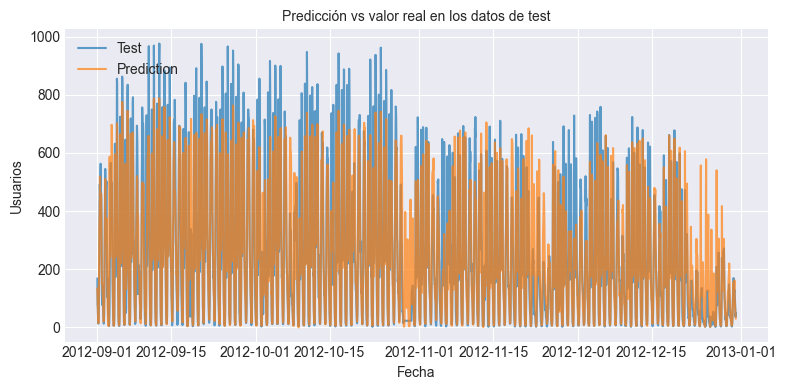

In [35]:

# Configuración de la figura
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar datos reales y predicciones
ax.plot(datos_test.index, datos_test['users'], label="Test", linestyle='-', alpha=0.7)
ax.plot(predicciones.index, predicciones['pred'], label="Prediction", linestyle='-', alpha=0.7)

# Configuración del gráfico
ax.set_xlabel("Fecha")
ax.set_ylabel("Usuarios")
ax.set_title("Predicción vs valor real en los datos de test", fontsize=10)
ax.legend(loc='upper left')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


La incorporación de variables exógenas mejora aún más la capacidad predictiva del modelo.

## Selección de predictores

La selección de predictores (feature selection) es el proceso de identificar un subconjunto de predictores relevantes para su uso en la creación del modelo. Es un paso importante en el proceso de machine learning, ya que puede ayudar a reducir el sobreajuste, mejorar la precisión del modelo y reducir el tiempo de entrenamiento. Dado que los regresores subyacentes de skforecast siguen la API de scikit-learn, es posible utilizar los métodos de selección de predictores disponibles en scikit-learn. Dos de los métodos más populares son **Recursive Feature Elimination** y **Sequential Feature Selection**.

#### **Nota**:
La selección de predictores es una herramienta potente para mejorar el rendimiento de los modelos de machine learning. Sin embargo, es computacionalmente costosa y puede requerir mucho tiempo. Dado que el objetivo es encontrar el mejor subconjunto de predictores, no el mejor modelo, no es necesario utilizar todos los datos disponibles ni un modelo muy complejo. En su lugar, se recomienda utilizar un pequeño subconjunto de los datos y un modelo sencillo. Una vez identificados los mejores predictores, el modelo puede entrenarse utilizando todo el conjunto de datos y una configuración más compleja.

In [36]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 

# Crear forecaster
regressor = LGBMRegressor(
    n_estimators = 100,
    max_depth = 5,
    random_state = 15926,
    verbose = -1
)

forecaster = ForecasterRecursive(
    regressor        = regressor,
    lags             = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)

# Eliminación recursiva de predictores con validación cruzada
selector = RFECV(
    estimator              = regressor,
    step                   = 1,
    cv                     = 3,
    min_features_to_select = 25,
    n_jobs                 = -1
)
lags_seleccionados,window_feature_selected, exog_seleccionadas = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = datos_train['users'],
    exog            = datos_train[exog_cols],
    select_only     = None,
    force_inclusion = None,
    subsample       = 0.5,
    random_state    = 123,
    verbose         = True,
)

c:\Users\ronal\AppData\Local\pypoetry\Cache\virtualenvs\machine_learning_complementary-EWj8ilj5-py3.11\Lib\site-packages\sklearn\utils\_tags.py:354: DeprecationWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\ronal\AppData\Local\pypoetry\Cache\virtualenvs\machine_learning_complementary-EWj8ilj5-py3.11\Lib\site-packages\sklearn\utils\_tags.py:354: DeprecationWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 10607
Total number of records used for feature selection: 5303
Number of features available: 98
    Lags            (n=9)
    Window features (n=0)
    Exog            (n=89)
Number of features selected: 29
    Lags            (n=9) : [1, 2, 3, 23, 24, 25, 167, 168, 169]
    Window features (n=0) : []
    Exog            (n=20) : ['weather', 'hora_dia_seno', 'hora_dia_coseno', 'poly_mes_seno__semana_anyo_seno', 'poly_mes_seno__dia_semana_seno', 'poly_semana_anyo_seno__dia_semana_coseno', 'poly_semana_anyo_seno__hora_dia_seno', 'poly_semana_anyo_seno__hora_dia_coseno', 'poly_semana_anyo_seno__hora_amanecer_coseno', 'poly_semana_anyo_coseno__dia_semana_seno', 'poly_semana_anyo_coseno__hora_dia_coseno', 'poly_dia_semana_seno__dia_semana_coseno', 'poly_dia_semana_seno__hora_dia_seno', 'poly_dia_semana_seno__hora_dia_coseno', 'poly_dia_semana_coseno__hora_dia_coseno', 'poly_hora_di

c:\Users\ronal\AppData\Local\pypoetry\Cache\virtualenvs\machine_learning_complementary-EWj8ilj5-py3.11\Lib\site-packages\sklearn\utils\_tags.py:354: DeprecationWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\ronal\AppData\Local\pypoetry\Cache\virtualenvs\machine_learning_complementary-EWj8ilj5-py3.11\Lib\site-packages\sklearn\utils\_tags.py:354: DeprecationWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn

El RFECV de scikit-learn empieza entrenando un modelo con todos los predictores disponibles y calculando la importancia de cada uno en base a los atributos como coef_ o feature_importances_. A continuación, se elimina el predictor menos importante y se realiza una validación cruzada para calcular el rendimiento del modelo con los predictores restantes. Este proceso se repite hasta que la eliminación de predictores adicionales no mejora la metrica de rendimiento elegida o se alcanza el min_features_to_select.

El resultado final es un subconjunto de predictores que idealmente equilibra la simplicidad del modelo y su capacidad predictiva, determinada por el proceso de validación cruzada.

El forecater se entrena y evalúa de nuevo utilizando el conjunto de predictores seleccionados.

In [37]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 

# Crear forecaster con los predictores seleccionados

forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags             = lags_seleccionados,
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
# Backtesting model with exogenous variables on test data
cv = TimeSeriesFold(
        steps              = 36,
        initial_train_size = len(datos[:fin_validacion]),
        refit              = False,
)


metrica_lgbm, predicciones = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos['users'],
    exog               = datos[exog_seleccionadas],
    cv=cv,
    metric             = 'mean_absolute_error',
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
metrica_lgbm

  0%|          | 0/81 [00:00<?, ?it/s]

,mean_absolute_error
0,54.017705


El rendimiento del modelo sigue siendo similar al del modelo entrenado con todas las variables. Sin embargo, el modelo es ahora mucho más simple, lo que hará que sea más rápido de entrenar y menos propenso al sobreajuste. Para el resto del documento, el modelo se entrenará utilizando sólo las variables seleccionadas.

In [38]:
# Actualizar las variables exógenas utilizadas
exog_cols = exog_seleccionadas

## Forecasting probabilístico: intervalos de predicción

Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de la variable respuesta con una determinada probabilidad. Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría los cuales requieren que los resudios (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es uno de los métodos disponibles en skforecast. Se pude encontrar una explicación más detallada de los intervalos de predicción en Probabilistic forecasting: prediction intervals and prediction distribution.

El siguiente código muestra cómo generar intervalos de predicción con un modelo autorregresivo. La función prediction_interval() se utiliza para estimar los intervalos para cada step predicho. Después, se utiliza la función backtesting_forecaster() para generar los intervalos de predicción de todo el conjunto de test. El argumento interval se utiliza para especificar la probabilidad de cobertura deseada de los intervalos. En este caso, interval se establece en [10, 90], lo que significa que los intervalos se calculan con los percentiles 10 y 90, lo que da como resultado una cobertura teórica del 80%. El argumento n_boot se utiliza para especificar el número de iteraciones de bootstraping que se utilizan para estimar los intervalos. Cuanto mayor sea el número de muestras, más precisos serán los intervalos de predicción, pero más tiempo tardará el proceso.

In [39]:
# Crear y entrenar forecaster
forecaster = ForecasterRecursive(
    regressor          = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags               = 72,
    transformer_exog   = transformer_exog,
    fit_kwargs         = {"categorical_feature": "auto"},
    binner_kwargs      = {"n_bins": 20}
)
forecaster.fit(
    y    = datos.loc[:fin_train, 'users'],
    exog = datos.loc[:fin_train, exog_cols]
)

In [40]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 

# Predicción de intervalos
# Como el modelo ha sido entrenado con variables exógenas, se tienen que pasar
# para las predicciones.
predictions = forecaster.predict_interval(
    exog     = datos.loc[fin_train:, exog_cols],
    steps    = 24,
    interval = [5, 95], 
)
predictions.head()

,pred,lower_bound,upper_bound
2012-04-01 00:00:00,77.836839,40.726734,115.018162
2012-04-01 01:00:00,58.670919,12.228280,108.200214
2012-04-01 02:00:00,38.890497,7.891687,130.013580
2012-04-01 03:00:00,21.642701,-21.255865,144.291034
2012-04-01 04:00:00,8.641283,-23.197179,134.328223


Por defecto, los intervalos se calculan utilizando los residuos in-sample (residuos del conjunto de entrenamiento). Sin embargo, esto puede dar lugar a intervalos demasiado estrechos (demasiado optimistas). Para evitarlo, se utiliza el método **set_out_sample_residuals()** para almacenar residuos out-sample calculados mediante backtesting con un conjunto de validación.

Si además de los residuos, se le pasan las correspondientes predicciones al método **set_out_sample_residuals()**, entonces los residuos utilizados en el proceso de bootstrapping se seleccionan condicionados al rango de valores de las predicciones. Esto puede ayudar a conseguir intervalos con mayor covertura a la vez que se mantienen lo más estrechos posibles.

In [41]:
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn") 

cv = TimeSeriesFold(
        initial_train_size = len(datos.loc[:fin_train]),
        steps              = 24,
        refit              = False,
        fixed_train_size   = False,)

# Backtesting con los datos de validación para obtener residuos out-sample
_, predictions_val = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = datos.loc[:fin_validacion, 'users'],
    exog               = datos.loc[:fin_validacion, exog_cols],
    metric             = 'mean_absolute_error',
    cv=cv,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)
residuals = datos.loc[predictions_val.index, 'users'] - predictions_val['pred']
residuals = residuals.dropna()

  0%|          | 0/153 [00:00<?, ?it/s]

positive    1903
negative    1769
Name: count, dtype: int64


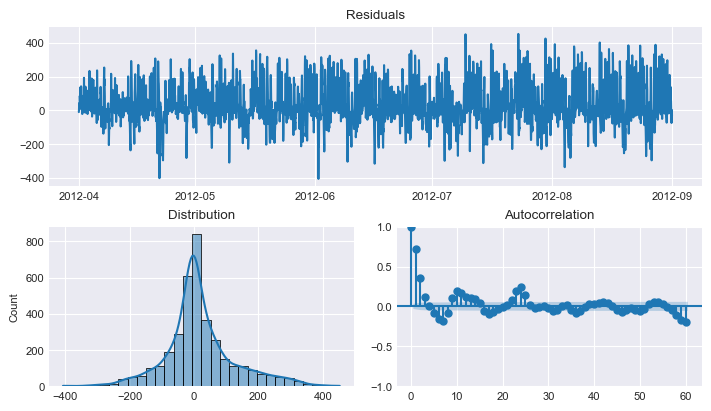

In [42]:
# Distribución de los residuos out-sample
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [43]:
# Almacenar residuos out-sample en el forecaster
forecaster.set_out_sample_residuals(
    y_true    = datos.loc[predictions_val.index, 'users'],
    y_pred    = predictions_val['pred']
)

A continuación, se ejecuta el proceso de backtesting para generar los intervalos de predicción en el conjunto de test. Se indica el argumento in_sample_residuals en False para que se utilicen los residuos out-sample almacenados previamente.

In [44]:

# Backtesting with prediction intervals in test data using out-sample residuals
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(datos.loc[:fin_validacion]),
        refit              = False,
    )


fin_test = '2012-10-31 23:00:00'
metric, predictions = backtesting_forecaster(
   forecaster          = forecaster,
   y                   = datos.loc[:fin_test, 'users'],
   exog                = datos.loc[:fin_test, exog_cols],
   cv=cv,
   metric              = 'mean_absolute_error',
   interval            = [5, 95],
   n_boot              = 20,#Era 200 pero tardaba mucho
   use_in_sample_residuals = False, # Use out-sample residuals
   use_binned_residuals    = True, # Residuals conditioned on predicted values
   n_jobs              = -1,
   verbose             = False,
   show_progress       = True
)
predictions.head()

  0%|          | 0/61 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-09-01 00:00:00,137.172396,44.176069,199.091370
2012-09-01 01:00:00,96.171805,22.279417,180.248894
2012-09-01 02:00:00,66.956182,12.839978,173.054992
2012-09-01 03:00:00,30.264881,1.162975,182.064719
2012-09-01 04:00:00,7.113325,2.768148,135.891309


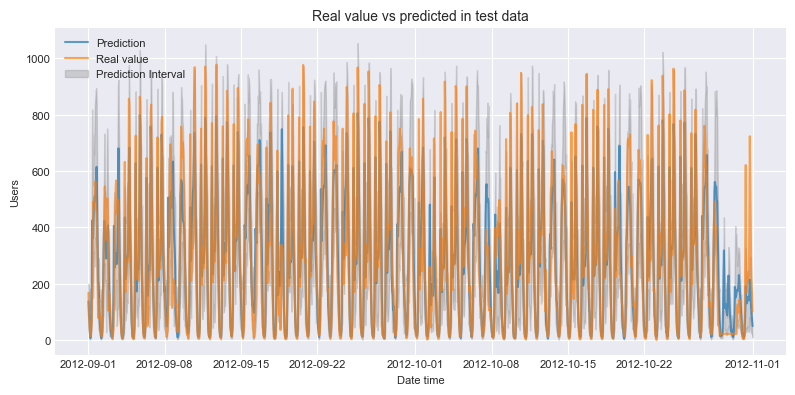

In [45]:
# Configuración de la figura
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar las predicciones y valores reales
ax.plot(predictions.index, predictions['pred'], label='Prediction', linestyle='-', alpha=0.7)
ax.plot(datos_test.loc[:fin_test].index, datos_test.loc[:fin_test, 'users'], label='Real value', linestyle='-', alpha=0.7)

# Graficar las bandas de predicción
ax.fill_between(
    predictions.index, predictions['lower_bound'], predictions['upper_bound'], 
    color='gray', alpha=0.3, label='Prediction Interval'
)

# Ajustes del gráfico
ax.set_xlabel("Date time")
ax.set_ylabel("Users")
ax.set_title("Real value vs predicted in test data", fontsize=10)
ax.legend()

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [46]:
predictions

,pred,lower_bound,upper_bound
2012-09-01 00:00:00,137.172396,44.176069,199.091370
2012-09-01 01:00:00,96.171805,22.279417,180.248894
2012-09-01 02:00:00,66.956182,12.839978,173.054992
2012-09-01 03:00:00,30.264881,1.162975,182.064719
2012-09-01 04:00:00,7.113325,2.768148,135.891309
...,...,...,...
2012-10-31 19:00:00,137.994630,34.280269,215.020376
2012-10-31 20:00:00,107.017301,25.113624,208.420203
2012-10-31 21:00:00,83.389709,24.043457,138.112308
2012-10-31 22:00:00,69.261293,18.168364,103.736006


In [47]:
# Cobertura del intervalo en los datos de test
coverage = np.mean(
    np.logical_and(
        datos.loc[fin_validacion:fin_test, 'users'] >= predictions["lower_bound"],
        datos.loc[fin_validacion:fin_test, 'users'] <= predictions["upper_bound"]
    )
)
area = (predictions['upper_bound'] - predictions['lower_bound']).sum()
print(f"Total area of the interval: {round(area, 2)}")
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Total area of the interval: 438022.57
Predicted interval coverage: 88.8 %


Utilizando los residuos out-sample (condicionados al valor de la predicción), la cobertura empírica observada es muy próxima a la cobertura teórica esperada (80%).

## Explicabilidad del modelo
Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: model-specific feature importances, SHAP values, and partial dependence plots.

In [48]:
# Crear y entrenar el forecaster
forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(**best_params, random_state=15926, verbose=-1),
    lags      = [1, 2, 3, 23, 24, 25, 167, 168, 169],
    transformer_exog = transformer_exog,
    fit_kwargs       = {"categorical_feature": "auto"}
)
forecaster.fit(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)

In [49]:
# Extraer importancia de los predictores
importancia = forecaster.get_feature_importances()
importancia.head(10)

,feature,importance
0,lag_1,3009
8,lag_169,1529
7,lag_168,1337
1,lag_2,1171
10,hora_dia_seno,1126
6,lag_167,1080
2,lag_3,1037
4,lag_24,902
11,hora_dia_coseno,806
3,lag_23,743


## Shap values

Los valores SHAP (SHapley Additive exPlanations) son un método muy utilizado para explicar los modelos de machine learning, ya que ayudan a comprender cómo influyen las variables y los valores en las predicciones de forma visual y cuantitativa.

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

- El regresor interno del forecaster.

- Las matrices de entrenamiento creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el forecaster.

Aprovechando estos dos componentes, los usuarios pueden crear explicaciones interpretables para sus modelos de skforecast. Estas explicaciones pueden utilizarse para verificar la fiabilidad del modelo, identificar los factores más significativos que contribuyen a las predicciones y comprender mejor la relación subyacente entre las variables de entrada y la variable objetivo.

In [50]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor
X_train, y_train = forecaster.create_train_X_y(
    y    = datos.loc[:fin_validacion, 'users'],
    exog = datos.loc[:fin_validacion, exog_cols]
)
display(X_train.head())
display(y_train.head())

,lag_1,lag_2,lag_3,lag_23,lag_24,lag_25,lag_167,lag_168,lag_169,weather,...,poly_semana_anyo_coseno__hora_dia_coseno,poly_dia_semana_seno__dia_semana_coseno,poly_dia_semana_seno__hora_dia_seno,poly_dia_semana_seno__hora_dia_coseno,poly_dia_semana_coseno__hora_dia_coseno,poly_hora_dia_seno__hora_dia_coseno,poly_hora_dia_seno__hora_anochecer_seno,poly_hora_dia_coseno__hora_anochecer_seno,temp_roll_mean_1_dia,temp
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-15 01:00:00,28.0,27.0,36.0,1.0,5.0,14.0,16.0,16.0,25.0,1,...,8.408603e-01,-0.487464,-0.390916,-6.770859e-01,5.399580e-01,4.330127e-01,-0.482963,-8.365163e-01,6.594167,6.56
2011-01-15 02:00:00,20.0,28.0,27.0,1.0,1.0,5.0,7.0,16.0,16.0,1,...,6.865596e-01,-0.487464,-0.552838,-5.528383e-01,4.408739e-01,5.000000e-01,-0.683013,-6.830127e-01,6.696667,6.56
2011-01-15 03:00:00,12.0,20.0,28.0,1.0,1.0,1.0,1.0,7.0,16.0,1,...,4.854709e-01,-0.487464,-0.677086,-3.909158e-01,3.117449e-01,4.330127e-01,-0.836516,-4.829629e-01,6.799167,6.56
2011-01-15 04:00:00,8.0,12.0,20.0,8.0,1.0,1.0,5.0,1.0,7.0,1,...,2.512982e-01,-0.487464,-0.755191,-2.023529e-01,1.613710e-01,2.500000e-01,-0.933013,-2.500000e-01,6.901667,6.56
2011-01-15 05:00:00,5.0,8.0,12.0,17.0,8.0,1.0,2.0,5.0,1.0,0,...,5.945304e-17,-0.487464,-0.781832,-4.787337e-17,3.817774e-17,6.123234e-17,-0.965926,-5.914590e-17,7.004167,6.56


date_time
2011-01-15 01:00:00    20.0
2011-01-15 02:00:00    12.0
2011-01-15 03:00:00     8.0
2011-01-15 04:00:00     5.0
2011-01-15 05:00:00     1.0
Freq: h, Name: y, dtype: float32

In [51]:
# Crear SHAP explainer (para modelos basados en árboles)
explainer = shap.TreeExplainer(forecaster.regressor)

# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

**NOTA**:
La librería Shap cuenta con varios *Explainers*, cada uno diseñado para un tipo de modelo diferente. El shap.TreeExplainer explainer se utiliza para modelos basados en árboles, como el LGBMRegressor utilizado en este ejemplo.

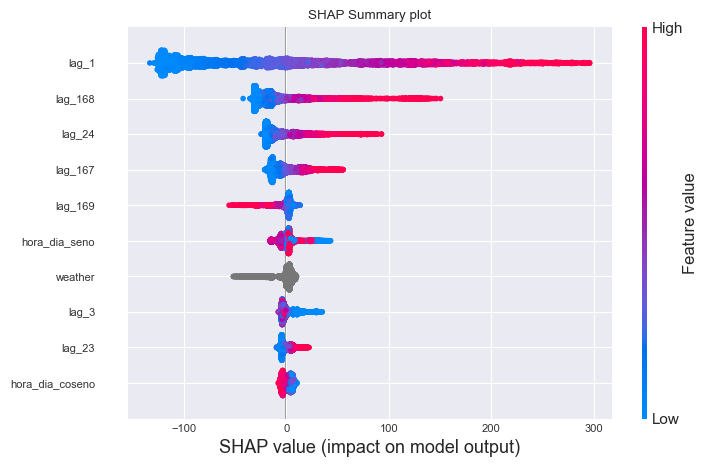

In [52]:
# Shap summary plot (top 10)
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [53]:
# Force plot para la primera observación de la muestra
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])